## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import torch; print(torch.cuda.is_available())
gpu_mem_get()


True


GPUMemory(total=4042, free=3821, used=221)

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/yuri/.fastai/data/camvid/labels'),
 PosixPath('/home/yuri/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/yuri/.fastai/data/camvid/images'),
 PosixPath('/home/yuri/.fastai/data/camvid/valid.txt')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'
path

PosixPath('/home/yuri/.fastai/data/camvid')

## Subset classes

In [ ]:
#path = Path('./data/camvid-small')
#
#def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name
#
#codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])
#
#src = (SegmentationItemList.from_folder(path)
 #      .split_by_folder(valid='val')
  #     .label_from_func(get_y_fn, classes=codes))
#
#bs=8
#data = (src.transform(get_transforms(), tfm_y=True)
 #       .databunch(bs=bs)
  #      .normalize(imagenet_stats))

## Data

In [ ]:
help(get_image_files)

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/yuri/.fastai/data/camvid/images/0016E5_07740.png'),
 PosixPath('/home/yuri/.fastai/data/camvid/images/0016E5_06060.png'),
 PosixPath('/home/yuri/.fastai/data/camvid/images/Seq05VD_f00570.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/yuri/.fastai/data/camvid/labels/Seq05VD_f04590_P.png'),
 PosixPath('/home/yuri/.fastai/data/camvid/labels/0006R0_f03870_P.png'),
 PosixPath('/home/yuri/.fastai/data/camvid/labels/Seq05VD_f03600_P.png')]

(PosixPath('/home/yuri/.fastai/data/camvid/images/0016E5_07740.png'),
 PosixPath('/home/yuri/.fastai/data/camvid/labels'))

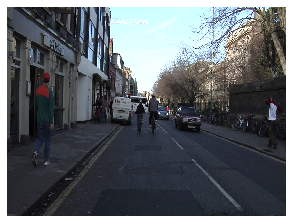

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

img_f, path_lbl

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

PosixPath('/home/yuri/.fastai/data/camvid/labels')

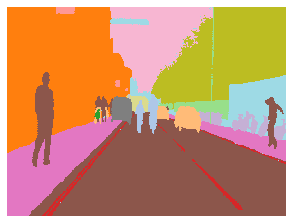

In [11]:

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

path_lbl

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]),
 tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [14]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=2, have 3821MB of GPU RAM free


In [ ]:
help(SegmentationItemList.from_folder())

In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(2, figsize=(10,7))

In [ ]:
import gc; gc.collect()

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc_camvid
# metrics=accuracy

In [19]:
wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1', return_path=True)

In [ ]:
help(learn.save)

In [ ]:
learn.path

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_lr()

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
learn.purge()

In [23]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 3450MB of GPU RAM free


In [24]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [25]:
learn = unet_learner(data, models.resnet34, wd=wd, metrics=metrics).to_fp16()

In [26]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


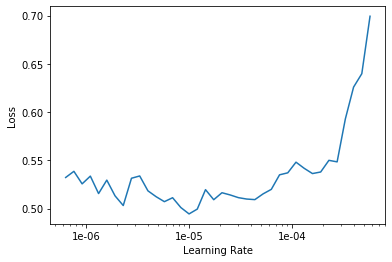

In [27]:
lr_find(learn)
learn.recorder.plot()

In [28]:
lr=1e-3

In [29]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.442497,0.337253,0.901925,07:59
1,0.529772,0.400358,0.894304,07:59
2,0.530197,0.464112,0.866013,07:58
3,0.561212,0.455942,0.881702,07:57
4,0.513736,0.497964,0.873252,07:57
5,0.500364,0.370205,0.903672,07:56
6,0.473770,0.421034,0.885379,07:55
7,0.421096,0.383387,0.895991,07:55
8,0.352994,0.276076,0.929677,07:54
9,0.276063,0.240607,0.934291,07:54


In [30]:
learn.save('stage-1-big')

In [31]:
learn.path

PosixPath('/home/yuri/.fastai/data/camvid/images')

In [32]:
learn.load('stage-1-big');

In [33]:
learn.unfreeze()

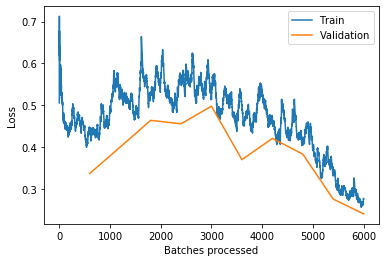

In [35]:
learn.recorder.plot_losses()

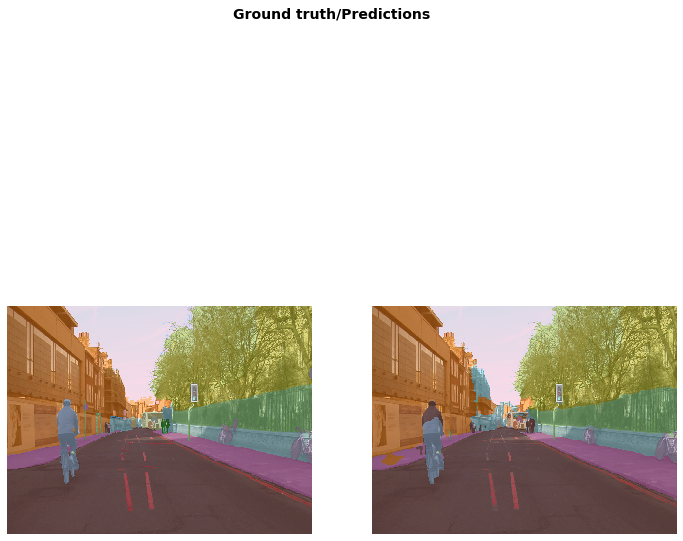

In [38]:
learn.show_results(rows=5, figsize=(12,12))

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin